# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [0]:
!pip install protobuf tqdm wheel
!git clone --branch=stable https://github.com/bigartm/bigartm.git
%cd bigartm
!mkdir build
%cd build
!cmake ..
!make
!pip install python/bigartm*.whl

In [0]:
import artm

In [0]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid", {'axes.grid' : False})

In [0]:
import numpy as np
import pandas as pd
from sklearn.externals import joblib

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [7]:
import urllib.request

testfile = urllib.request.URLopener()
testfile.retrieve("https://raw.githubusercontent.com/OzmundSedler/100-Days-Of-ML-Code/master/week_9/datasets/lectures.txt", "lectures.txt")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  exec(code_obj, self.user_global_ns, self.user_ns)


('lectures.txt', <http.client.HTTPMessage at 0x7f65a611f400>)

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path='lectures.txt', data_format='vowpal_wabbit',
                                        target_folder='lectures_batches', batch_size=250)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [0]:
T = 30   
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]

model = artm.ARTM(num_topics=T, topic_names=topic_names, num_processors=2, class_ids={'text':1, 'author':1},
                  reuse_theta=True, cache_theta=True)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [0]:
np.random.seed(1)
dictionary = artm.Dictionary('dict')
dictionary.gather(batch_vectorizer.data_path)
model.initialize(dictionary=dictionary)

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [0]:
model.scores.add(artm.TopTokensScore(name='top_tokens_score_mod1', class_id='text', num_tokens=15))
model.scores.add(artm.TopTokensScore(name='top_tokens_score_mod2', class_id='author', num_tokens=15))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [0]:
# Ваш код
model.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=1e5, class_ids='text', dictionary='dict', topic_names='bcg'))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [0]:
# Ваш код
model.num_document_passes = 1
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [0]:
# Ваш код
topic_names_cleared = list(topic_names).remove('bcg')
model.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=-1e5, class_ids='text', dictionary='dict',
                                                       topic_names=topic_names_cleared))

Выполните еще 15 проходов по коллекции.

In [0]:
# Ваш код
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [19]:
# Ваш код
tokens = model.score_tracker['top_tokens_score_mod1'].last_tokens
for topic_name in model.topic_names:
    print (topic_name + ': ')
    print (*tokens[topic_name], sep=', ')
    print()

sbj0: 
церковь, власть, средневековый, император, русь, святой, римский, папа, князь, сага, король, александр, византийский, вера, рим

sbj1: 
планета, земля, атмосфера, солнце, солнечный, белый, газ, образовываться, карлик, вокруг, вода, поверхность, спутник, орбита, океан

sbj2: 
система, трудность, поведение, частота, двигаться, точность, искусственный, движение, относительность, тест, час, самка, задание, переход, часы

sbj3: 
культура, понятие, культурный, восприятие, сознание, феномен, личность, воспринимать, ощущение, чувство, повседневный, переживание, детство, этика, индивид

sbj4: 
право, литература, искусство, литературный, юрист, писатель, должник, собственность, обязательство, владение, произведение, римский, исполнение, юридический, требование

sbj5: 
материал, структура, молекула, свойство, углерод, применение, поверхность, полимер, кристалл, металл, электронный, твердый, трехмерный, алмаз, углеродный

sbj6: 
книга, фильм, автор, кино, написать, документ, жанр, театр, те

In [20]:
# Ваш код
authors = model.score_tracker['top_tokens_score_mod2'].last_tokens
for topic_name in model.topic_names:
    print (topic_name + ': ')
    print (*authors[topic_name], sep=', ')
    print()

sbj0: 
Александр_Марей, Фёдор_Успенский, Татьяна_Бобровникова, Павел_Уваров, Алексей_Юдин, Игорь_Данилевский, Ольга_Вайнштейн, Елена_Уханова, Ольга_Брилева, Владимир_Петрухин, Елена_Браун, Григорий_Бондаренко, Раиса_Кирсанова, Екатерина_Болтунова, Ольга_Тогоева

sbj1: 
Сергей_Попов, Кирилл_Еськов, Дмитрий_Вибе, Дмитрий_Титов, Валерий_Сулейманов, Зоригто_Намсараев, Сергей_Наугольных, Александр_Марков, Роман_Рафиков, Александр_Слободкин, Елизавета_Ривкина, Наталья_Новикова, Сергей_Писарев, Дмитрий_Лось, Юлия_Краус

sbj2: 
Елена_Брызгалина, Михаил_Пантелеев, Владимир_Мележик, Александр_Поддьяков, Эмиль_Ахмедов, Антон_Суворов, Даниэль_Сельва, Виталий_Пальчиков, Михаил_Фейгельман, Василий_Климов, Алексей_Желтиков, Юджин_Ползик, Илья_Щуров, Владимир_Редько, Кристофер_Уиншип

sbj3: 
Алексей_Руткевич, Сергей_Арутюнов, Владимир_Миронов, Пётр_Турчин, Татьяна_Смоктунович, Андрей_Лосев, Константин_Анохин, Кирилл_Разлогов, Дмитрий_Иванов, Фёдор_Гиренок, Павел_Умрюхин, Павел_Степанцов, Александр_Кис

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [0]:
sbj_topic_labels = []   # запишите названия тем в список
for topic_name in model.topic_names[:29]:
    sbj_topic_labels.append(tokens[topic_name][0])

topic_labels = sbj_topic_labels + [u"Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [22]:
model.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
theta = model.get_theta()
print('Theta shape: %s' % str(theta.shape))
phi_a = model.get_phi(class_ids='author')
print('Phi_a shape: %s' % str(phi_a.shape))

Theta shape: (30, 1728)
Phi_a shape: (539, 30)


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

In [23]:
# Ваш код
theta.iloc[:,:100]

,http://postnauka.ru/video/10006,http://postnauka.ru/video/10379,http://postnauka.ru/video/10380,http://postnauka.ru/video/10381,http://postnauka.ru/video/10382,http://postnauka.ru/video/10383,http://postnauka.ru/video/10384,http://postnauka.ru/video/10385,http://postnauka.ru/video/10473,http://postnauka.ru/video/10475,http://postnauka.ru/video/10477,http://postnauka.ru/video/10749,http://postnauka.ru/video/10750,http://postnauka.ru/video/10751,http://postnauka.ru/video/10753,http://postnauka.ru/video/10754,http://postnauka.ru/video/10755,http://postnauka.ru/video/10756,http://postnauka.ru/video/10757,http://postnauka.ru/video/10759,http://postnauka.ru/video/10773,http://postnauka.ru/video/10777,http://postnauka.ru/video/10778,http://postnauka.ru/video/10779,http://postnauka.ru/video/10783,http://postnauka.ru/video/10784,http://postnauka.ru/video/10786,http://postnauka.ru/video/10788,http://postnauka.ru/video/11023,http://postnauka.ru/video/11034,http://postnauka.ru/video/11061,http://postnauka.ru/video/11246,http://postnauka.ru/video/11248,http://postnauka.ru/video/11250,http://postnauka.ru/video/11353,http://postnauka.ru/video/11361,http://postnauka.ru/video/11363,http://postnauka.ru/video/11390,http://postnauka.ru/video/11458,http://postnauka.ru/video/11509,...,http://postnauka.ru/video/12083,http://postnauka.ru/video/12085,http://postnauka.ru/video/12125,http://postnauka.ru/video/12146,http://postnauka.ru/video/12148,http://postnauka.ru/video/12149,http://postnauka.ru/video/12151,http://postnauka.ru/video/12154,http://postnauka.ru/video/12156,http://postnauka.ru/video/12172,http://postnauka.ru/video/12259,http://postnauka.ru/video/12290,http://postnauka.ru/video/12291,http://postnauka.ru/video/12371,http://postnauka.ru/video/12372,http://postnauka.ru/video/12373,http://postnauka.ru/video/12374,http://postnauka.ru/video/12375,http://postnauka.ru/video/12376,http://postnauka.ru/video/12383,http://postnauka.ru/video/12515,http://postnauka.ru/video/12517,http://postnauka.ru/video/12518,http://postnauka.ru/video/12521,http://postnauka.ru/video/12523,http://postnauka.ru/video/12524,http://postnauka.ru/video/12527,http://postnauka.ru/video/12574,http://postnauka.ru/video/12576,http://postnauka.ru/video/12738,http://postnauka.ru/video/12739,http://postnauka.ru/video/12740,http://postnauka.ru/video/12898,http://postnauka.ru/video/12904,http://postnauka.ru/video/12971,http://postnauka.ru/video/12974,http://postnauka.ru/video/13041,http://postnauka.ru/video/13042,http://postnauka.ru/video/13043,http://postnauka.ru/video/13092
sbj0,8.602642e-03,0.000000e+00,0.000000e+00,0.171630,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.111104e-01,0.000000e+00,2.957092e-08,0.029412,0.000000e+00,0.000000,0.000000e+00,2.105881e-13,0.003501,3.068327e-13,0.000000e+00,2.574793e-03,7.508454e-03,0.000000,0.000000e+00,0.078839,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.440134e-01,4.781892e-04,0.000000e+00,1.046662e-02,3.919291e-03,2.121198e-01,...,5.251402e-03,0.000000e+00,0.000000e+00,2.570231e-13,0.000000,0.000000e+00,0.000000e+00,9.593216e-02,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,2.822729e-05,1.524525e-05,0.000000e+00,0.000000,4.852223e-04,6.889118e-02,0.002776,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.105642e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.241231e-03,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,5.331597e-11
sbj1,0.000000e+00,0.000000e+00,2.735844e-02,0.000000,0.000000,0.000000,0.003059,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,3.342867e-03,0.000000,0.000000e+00,0.000000,5.810475e-02,4.730853e-02,0.075117,2.718144e-11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,2.256426e-01,0.000000e+00,0.000000e+00,0.000000,7.130320e-12,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.742406e-02,0.000000e+00,1.727379e-01,0.000000e+00,.

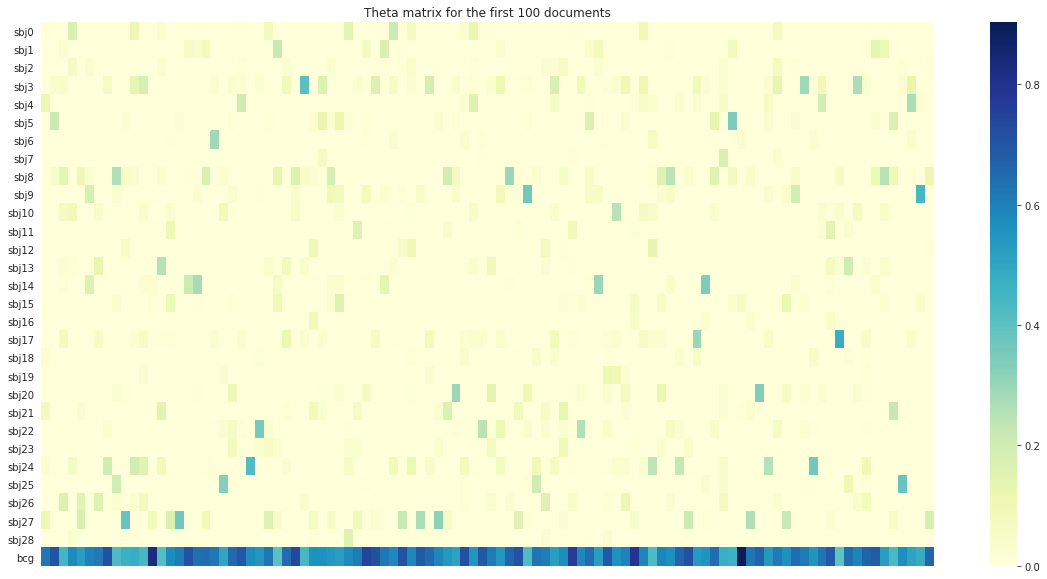

In [24]:
plt.figure(figsize=(20,10))
plt.title('Theta matrix for the first 100 documents')
sns.heatmap(theta.iloc[:,:100], cmap='YlGnBu', xticklabels=False)
plt.show();

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [25]:
# Ваш код
prob_theme_data = [np.sum(theta.iloc[i]) for i in range(theta.shape[0])]
prob_theme_data_normed = prob_theme_data / np.sum(prob_theme_data)
prob_theme = pd.DataFrame(data=prob_theme_data_normed, index=topic_labels, columns=['prob'])
prob_theme

,prob
церковь,0.011969
планета,0.012341
система,0.009094
культура,0.014261
право,0.008991
материал,0.010728
книга,0.007117
смерть,0.004947
метод,0.014190
частица,0.022603


In [26]:
prob_theme_max = prob_theme
prob_theme_min = prob_theme

print('Max 5 probabilities:')
for i in range(5):
    max_value = prob_theme_max.max()[0]
    print(prob_theme_max[prob_theme_max.values == max_value].index[0])
    prob_theme_max = prob_theme_max[prob_theme_max.values != max_value]

print('\nMin 3 probabilities:')
for i in range(3):
    min_value = prob_theme_min.min()[0]
    print(prob_theme_min[prob_theme_min.values == min_value].index[0])
    prob_theme_min = prob_theme_min[prob_theme_min.values != min_value]

Max 5 probabilities:
Фоновая тема
клетка
частица
звезда
политический

Min 3 probabilities:
раса
смерть
температура


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

Ваш ответ:
5 тем с max p(t):
Фоновая тема
клетка
частица
звезда
политический

3 темы с min p(t):
раса
смерть
температура

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

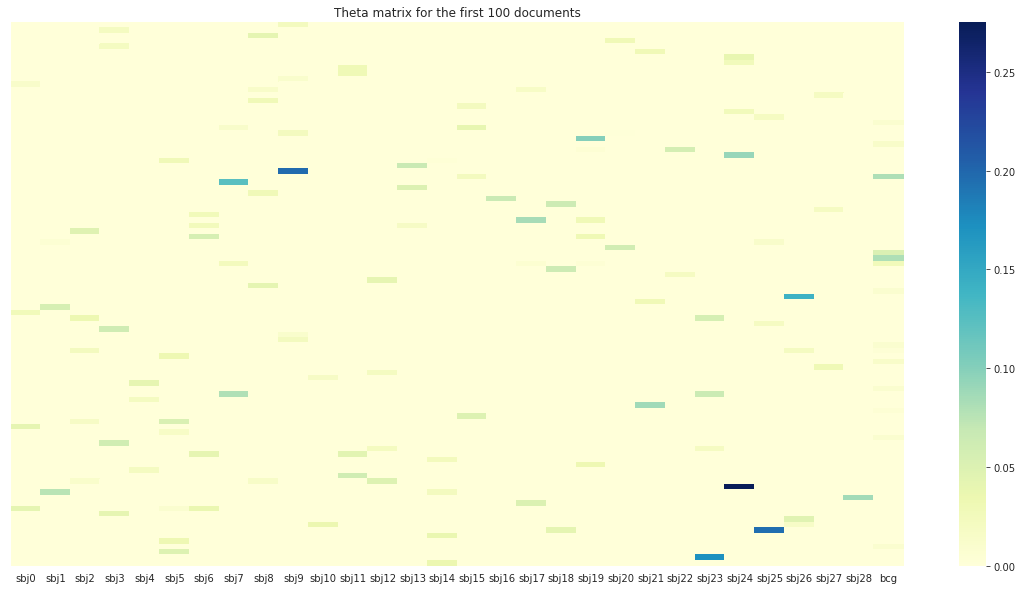

In [27]:
# Ваш код
plt.figure(figsize=(20,10))
plt.title('Theta matrix for the first 100 documents')
sns.heatmap(phi_a.iloc[:100], cmap='YlGnBu', yticklabels=False)
plt.show();

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [28]:
phi_a

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,sbj10,sbj11,sbj12,sbj13,sbj14,sbj15,sbj16,sbj17,sbj18,sbj19,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
"(author, Марина_Корсакова-Крейн)",0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2.325498e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
"(author, Ирина_Каспэ)",0.000000,0.000000,0.000000e+00,2.059141e-02,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
"(author, Александр_Беленький)",0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,4.261122e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
"(author, Дарья_Радченко)",0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,2.964206e-02,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
"(author, Андрей_Коротаев)",0.000000,0.000000,0.000000e+00,2.059141e-02,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
"(author, Елена_Голубева)",0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,2.931198e-02,0.000000,0.000000e+00,0.000000,0.000000e+00,1.189590e-09,0.000000e+00,0.000000e+00,0.000000
"(author, Галина_Зеленина)",0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.943091e-08,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,3.096623e-11,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.039309,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
"(author, Ирина_Левонтина)",0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.560702e-16,0.000000,0.000000e+00,0.026206,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
"(author, Михаил_Полуэктов)",0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,3.019959e-02,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
"(author, Алексей_Москалев)",0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,3.019959e-02,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000


In [29]:
for i in range(phi_a.shape[0]):
    num_valuble_topics = 0
    for val in phi_a.iloc[i]:
        if val > 0.01:
            num_valuble_topics += 1
    if num_valuble_topics >= 3:
        print(i),
        print(phi_a.index[i])

84


(None,)

('author', 'Андрей_Цатурян')
108


(None,)

('author', 'Елена_Брызгалина')
131


(None,)

('author', 'Дмитрий_Лось')
274


(None,)

('author', 'Алина_Бодрова')


In [30]:
print(phi_a.iloc[184])

sbj0     0.000000
sbj1     0.000000
sbj2     0.000000
sbj3     0.000000
sbj4     0.000000
sbj5     0.000000
sbj6     0.000000
sbj7     0.000000
sbj8     0.000000
sbj9     0.000000
sbj10    0.000000
sbj11    0.000000
sbj12    0.000000
sbj13    0.000000
sbj14    0.000000
sbj15    0.000000
sbj16    0.000000
sbj17    0.000000
sbj18    0.000000
sbj19    0.000000
sbj20    0.000000
sbj21    0.000000
sbj22    0.000000
sbj23    0.000000
sbj24    0.000000
sbj25    0.000000
sbj26    0.000000
sbj27    0.020223
sbj28    0.000000
bcg      0.000000
Name: (author, Дмитрий_Сорокин), dtype: float32


Ваш ответ:
авторы, значимые в не менее чем 3 темах:
184 Елена_Брызгалина
200 Андрей_Цатурян
229 Алина_Бодрова
342 Дмитрий_Лось

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [0]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [0]:
prob_theme_author = np.empty(phi_a.shape)
for i in range(prob_theme_author.shape[0]):
    for j in range(prob_theme_author.shape[1]):
        prob_theme_author[i,j] = phi_a.iloc[i,j] * prob_theme.iloc[j,:] / np.sum(phi_a.iloc[i,:] * prob_theme.prob.values)

In [0]:
# Ваш код
similarities = pairwise_distances(prob_theme_author, metric='cosine')
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pos = mds.fit_transform(similarities)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

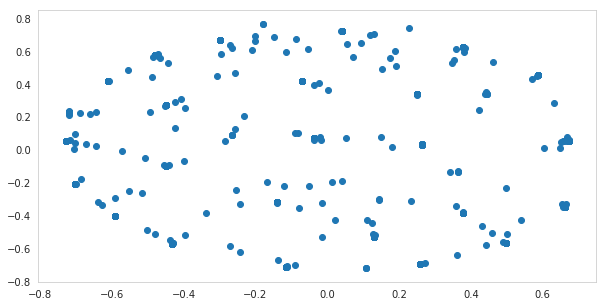

In [34]:
# Ваш код
plt.figure(figsize=(10,5))
plt.scatter(pos[:,0], pos[:,1])
plt.show();

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

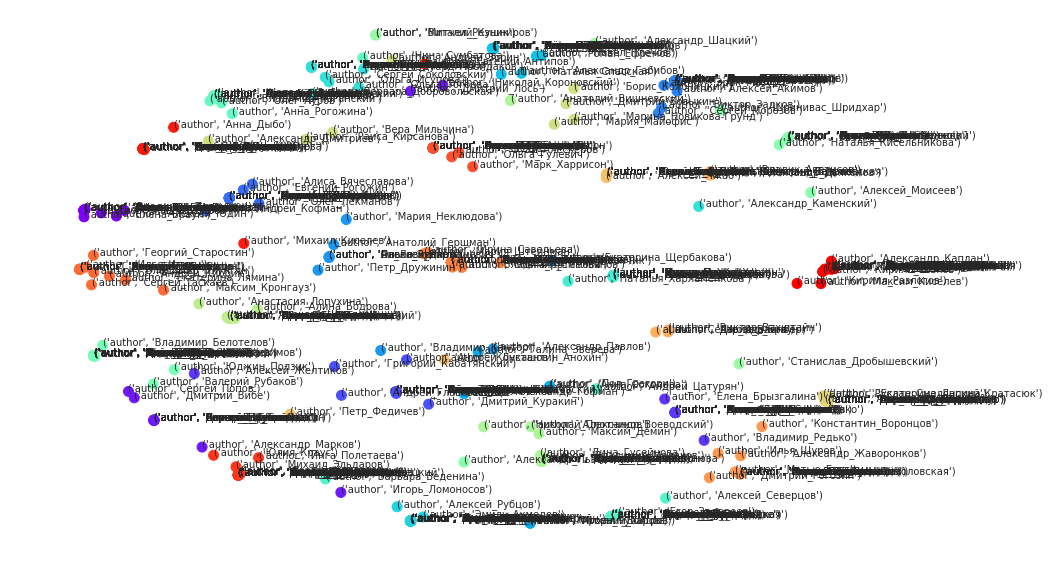

In [35]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
max_theme_prob_for_colors = [np.argmax(author) for author in prob_theme_author]
plt.figure(figsize=(15,10))
plt.axis('off')
plt.scatter(pos[:,0], pos[:,1], s=100, c=colors[max_theme_prob_for_colors])
for i, author in enumerate(phi_a.index):
        plt.annotate(author, pos[i])
plt.savefig('authors_map.pdf', dpi=200, format='pdf')
plt.show();

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [36]:
# Ваш код
prob_doc_theme = theta.values / np.array([np.sum(theme) for theme in theta.values])[:, np.newaxis]
prob_doc_theme_sorted_indices = prob_doc_theme.argsort(axis=1)[:,::-1]
prob_doc_theme_sorted_indices

array([[1442, 1007,  686, ...,  702, 1435,  863],
       [ 919,  497,  471, ...,  784,  779,    0],
       [ 503,  821,  880, ...,  374,  375,  863],
       ...,
       [1326,    9,  553, ...,  899,  898,  863],
       [ 398,  794,  442, ...,  921,  920,    0],
       [  78,  839,  778, ...,  919, 1468, 1403]])

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [38]:
print ("http://yandex.ru")   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [39]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [40]:
# Ваш код
for i, theme in enumerate(topic_labels):
    display(HTML("<h3>%s</h3>" % theme))
    for j in range(10):
        print(tokens[model.topic_names[i]][j]),
    print('')
    for k in range(10):
        print(theta.columns[prob_doc_theme_sorted_indices[i,k]])

церковь


(None,)

власть


(None,)

средневековый


(None,)

император


(None,)

русь


(None,)

святой


(None,)

римский


(None,)

папа


(None,)

князь


(None,)

сага


(None,)


http://postnauka.ru/video/9299
http://postnauka.ru/video/3348
http://postnauka.ru/video/24030
http://postnauka.ru/video/9968
http://postnauka.ru/video/23472
http://postnauka.ru/video/13156
http://postnauka.ru/video/31677
http://postnauka.ru/video/50350
http://postnauka.ru/video/24034
http://postnauka.ru/video/50668


планета


(None,)

земля


(None,)

атмосфера


(None,)

солнце


(None,)

солнечный


(None,)

белый


(None,)

газ


(None,)

образовываться


(None,)

карлик


(None,)

вокруг


(None,)


http://postnauka.ru/video/53693
http://postnauka.ru/video/32889
http://postnauka.ru/video/31695
http://postnauka.ru/video/51364
http://postnauka.ru/video/9835
http://postnauka.ru/video/36249
http://postnauka.ru/video/9690
http://postnauka.ru/video/49261
http://postnauka.ru/video/24245
http://postnauka.ru/video/37994


система


(None,)

трудность


(None,)

поведение


(None,)

частота


(None,)

двигаться


(None,)

точность


(None,)

искусственный


(None,)

движение


(None,)

относительность


(None,)

тест


(None,)


http://postnauka.ru/video/1856
http://postnauka.ru/video/51174
http://postnauka.ru/video/52553
http://postnauka.ru/video/34426
http://postnauka.ru/video/52548
http://postnauka.ru/video/51382
http://postnauka.ru/video/19509
http://postnauka.ru/video/21662
http://postnauka.ru/video/37982
http://postnauka.ru/video/41348


культура


(None,)

понятие


(None,)

культурный


(None,)

восприятие


(None,)

сознание


(None,)

феномен


(None,)

личность


(None,)

воспринимать


(None,)

ощущение


(None,)

чувство


(None,)


http://postnauka.ru/video/11034
http://postnauka.ru/video/12524
http://postnauka.ru/video/12740
http://postnauka.ru/video/5891
http://postnauka.ru/video/36707
http://postnauka.ru/video/7747
http://postnauka.ru/video/7169
http://postnauka.ru/video/9874
http://postnauka.ru/video/11626
http://postnauka.ru/video/7731


право


(None,)

литература


(None,)

искусство


(None,)

литературный


(None,)

юрист


(None,)

писатель


(None,)

должник


(None,)

собственность


(None,)

обязательство


(None,)

владение


(None,)


http://postnauka.ru/video/17913
http://postnauka.ru/video/31688
http://postnauka.ru/video/38009
http://postnauka.ru/video/34414
http://postnauka.ru/video/49455
http://postnauka.ru/video/14297
http://postnauka.ru/video/17825
http://postnauka.ru/video/13042
http://postnauka.ru/video/16822
http://postnauka.ru/video/42220


материал


(None,)

структура


(None,)

молекула


(None,)

свойство


(None,)

углерод


(None,)

применение


(None,)

поверхность


(None,)

полимер


(None,)

кристалл


(None,)

металл


(None,)


http://postnauka.ru/video/13544
http://postnauka.ru/video/12375
http://postnauka.ru/video/41686
http://postnauka.ru/video/31182
http://postnauka.ru/video/22592
http://postnauka.ru/video/46379
http://postnauka.ru/video/36492
http://postnauka.ru/video/36657
http://postnauka.ru/video/36490
http://postnauka.ru/video/47818


книга


(None,)

фильм


(None,)

автор


(None,)

кино


(None,)

написать


(None,)

документ


(None,)

жанр


(None,)

театр


(None,)

тема


(None,)

кинематограф


(None,)


http://postnauka.ru/video/10759
http://postnauka.ru/video/39723
http://postnauka.ru/video/13541
http://postnauka.ru/video/38510
http://postnauka.ru/video/42807
http://postnauka.ru/video/52416
http://postnauka.ru/video/47204
http://postnauka.ru/video/57127
http://postnauka.ru/video/47208
http://postnauka.ru/video/47202


смерть


(None,)

ритуал


(None,)

террор


(None,)

правитель


(None,)

государь


(None,)

обряд


(None,)

служба


(None,)

конвент


(None,)

диктатура


(None,)

моральный


(None,)


http://postnauka.ru/video/1893
http://postnauka.ru/video/48480
http://postnauka.ru/video/32882
http://postnauka.ru/video/37992
http://postnauka.ru/video/50656
http://postnauka.ru/video/48335
http://postnauka.ru/video/12374
http://postnauka.ru/video/1899
http://postnauka.ru/video/51331
http://postnauka.ru/video/21660


метод


(None,)

химический


(None,)

соединение


(None,)

вещество


(None,)

реакция


(None,)

химия


(None,)

давление


(None,)

лекарство


(None,)

синтез


(None,)

органический


(None,)


http://postnauka.ru/video/18048
http://postnauka.ru/video/11646
http://postnauka.ru/video/13700
http://postnauka.ru/video/19071
http://postnauka.ru/video/51490
http://postnauka.ru/video/24449
http://postnauka.ru/video/10473
http://postnauka.ru/video/13151
http://postnauka.ru/video/8953
http://postnauka.ru/video/7363


частица


(None,)

энергия


(None,)

квантовый


(None,)

поле


(None,)

физика


(None,)

взаимодействие


(None,)

атом


(None,)

магнитный


(None,)

теория


(None,)

электрон


(None,)


http://postnauka.ru/video/13043
http://postnauka.ru/video/18870
http://postnauka.ru/video/18873
http://postnauka.ru/video/11651
http://postnauka.ru/video/22760
http://postnauka.ru/video/24434
http://postnauka.ru/video/2945
http://postnauka.ru/video/14283
http://postnauka.ru/video/7753
http://postnauka.ru/video/7311


война


(None,)

россия


(None,)

советский


(None,)

русский


(None,)

власть


(None,)

российский


(None,)

германия


(None,)

мировой


(None,)

реформа


(None,)

историк


(None,)


http://postnauka.ru/video/35041
http://postnauka.ru/video/46939
http://postnauka.ru/video/19574
http://postnauka.ru/video/31183
http://postnauka.ru/video/29992
http://postnauka.ru/video/51180
http://postnauka.ru/video/26667
http://postnauka.ru/video/25906
http://postnauka.ru/video/42809
http://postnauka.ru/video/41895


ребенок


(None,)

семья


(None,)

возраст


(None,)

кровь


(None,)

взрослый


(None,)

мать


(None,)

сон


(None,)

родитель


(None,)

старение


(None,)

конфликт


(None,)


http://postnauka.ru/video/22892
http://postnauka.ru/video/59638
http://postnauka.ru/video/30678
http://postnauka.ru/video/60527
http://postnauka.ru/video/57657
http://postnauka.ru/video/18613
http://postnauka.ru/video/30606
http://postnauka.ru/video/17395
http://postnauka.ru/video/6377
http://postnauka.ru/video/29103


растение


(None,)

ткань


(None,)

орган


(None,)

иммунный


(None,)

рак


(None,)

озеро


(None,)

сердце


(None,)

опухоль


(None,)

мышца


(None,)

нейронный


(None,)


http://postnauka.ru/video/16821
http://postnauka.ru/video/23172
http://postnauka.ru/video/46562
http://postnauka.ru/video/13746
http://postnauka.ru/video/51169
http://postnauka.ru/video/51501
http://postnauka.ru/video/33793
http://postnauka.ru/video/18192
http://postnauka.ru/video/26213
http://postnauka.ru/video/59617


территория


(None,)

народ


(None,)

христианский


(None,)

империя


(None,)

восток


(None,)

древний


(None,)

письменность


(None,)

государство


(None,)

цивилизация


(None,)

китай


(None,)


http://postnauka.ru/video/53171
http://postnauka.ru/video/50071
http://postnauka.ru/video/2527
http://postnauka.ru/video/58742
http://postnauka.ru/video/59201
http://postnauka.ru/video/50066
http://postnauka.ru/video/49203
http://postnauka.ru/video/48959
http://postnauka.ru/video/46313
http://postnauka.ru/video/3387


звезда


(None,)

галактика


(None,)

масса


(None,)

черный


(None,)

вселенная


(None,)

свет


(None,)

объект


(None,)

скорость


(None,)

волна


(None,)

дыра


(None,)


http://postnauka.ru/video/6673
http://postnauka.ru/video/17780
http://postnauka.ru/video/31193
http://postnauka.ru/video/29998
http://postnauka.ru/video/30015
http://postnauka.ru/video/2971
http://postnauka.ru/video/23506
http://postnauka.ru/video/48109
http://postnauka.ru/video/23502
http://postnauka.ru/video/57338


задача


(None,)

информация


(None,)

память


(None,)

данные


(None,)

решение


(None,)

компьютер


(None,)

психология


(None,)

мышление


(None,)

анализ


(None,)

внимание


(None,)


http://postnauka.ru/video/24182
http://postnauka.ru/video/24451
http://postnauka.ru/video/5181
http://postnauka.ru/video/23763
http://postnauka.ru/video/53415
http://postnauka.ru/video/19577
http://postnauka.ru/video/56052
http://postnauka.ru/video/57336
http://postnauka.ru/video/50349
http://postnauka.ru/video/17421


раса


(None,)

африка


(None,)

остров


(None,)

америка


(None,)

южный


(None,)

станислав


(None,)

нос


(None,)

волос


(None,)

индия


(None,)

монголоид


(None,)


http://postnauka.ru/video/31707
http://postnauka.ru/video/32898
http://postnauka.ru/video/42707
http://postnauka.ru/video/49262
http://postnauka.ru/video/42735
http://postnauka.ru/video/37732
http://postnauka.ru/video/35150
http://postnauka.ru/video/40880
http://postnauka.ru/video/17397
http://postnauka.ru/video/36253


политический


(None,)

философия


(None,)

государство


(None,)

общество


(None,)

философский


(None,)

философ


(None,)

партия


(None,)

правовой


(None,)

политика


(None,)

суд


(None,)


http://postnauka.ru/video/12738
http://postnauka.ru/video/32906
http://postnauka.ru/video/2526
http://postnauka.ru/video/12371
http://postnauka.ru/video/3418
http://postnauka.ru/video/22975
http://postnauka.ru/video/36713
http://postnauka.ru/video/37965
http://postnauka.ru/video/2972
http://postnauka.ru/video/9728


слово


(None,)

текст


(None,)

русский


(None,)

словарь


(None,)

предложение


(None,)

категория


(None,)

значение


(None,)

корпус


(None,)

глагол


(None,)

конструкция


(None,)


http://postnauka.ru/video/36272
http://postnauka.ru/video/1898
http://postnauka.ru/video/6720
http://postnauka.ru/video/48960
http://postnauka.ru/video/47548
http://postnauka.ru/video/56616
http://postnauka.ru/video/51499
http://postnauka.ru/video/57524
http://postnauka.ru/video/30017
http://postnauka.ru/video/2946


революция


(None,)

французский


(None,)

свобода


(None,)

франция


(None,)

роман


(None,)

национальный


(None,)

король


(None,)

нация


(None,)

аргумент


(None,)

творчество


(None,)


http://postnauka.ru/video/5396
http://postnauka.ru/video/48492
http://postnauka.ru/video/43843
http://postnauka.ru/video/47823
http://postnauka.ru/video/22079
http://postnauka.ru/video/45548
http://postnauka.ru/video/53577
http://postnauka.ru/video/28944
http://postnauka.ru/video/54742
http://postnauka.ru/video/41671


город


(None,)

технология


(None,)

сеть


(None,)

робот


(None,)

городской


(None,)

интернет


(None,)

компания


(None,)

пользователь


(None,)

музей


(None,)

библиотека


(None,)


http://postnauka.ru/video/13742
http://postnauka.ru/video/12515
http://postnauka.ru/video/11634
http://postnauka.ru/video/9998
http://postnauka.ru/video/7068
http://postnauka.ru/video/47301
http://postnauka.ru/video/17604
http://postnauka.ru/video/30026
http://postnauka.ru/video/50792
http://postnauka.ru/video/29812


болезнь


(None,)

заболевание


(None,)

пациент


(None,)

женщина


(None,)

лечение


(None,)

медицина


(None,)

врач


(None,)

боль


(None,)

препарат


(None,)

медицинский


(None,)


http://postnauka.ru/video/2541
http://postnauka.ru/video/54325
http://postnauka.ru/video/27925
http://postnauka.ru/video/51384
http://postnauka.ru/video/55539
http://postnauka.ru/video/49206
http://postnauka.ru/video/12974
http://postnauka.ru/video/45961
http://postnauka.ru/video/13746
http://postnauka.ru/video/43853


социальный


(None,)

знание


(None,)

социология


(None,)

объект


(None,)

социологический


(None,)

дисциплина


(None,)

перевод


(None,)

познание


(None,)

обучение


(None,)

описание


(None,)


http://postnauka.ru/video/10783
http://postnauka.ru/video/434
http://postnauka.ru/video/3628
http://postnauka.ru/video/2530
http://postnauka.ru/video/6380
http://postnauka.ru/video/12083
http://postnauka.ru/video/11640
http://postnauka.ru/video/17491
http://postnauka.ru/video/4280
http://postnauka.ru/video/14295


матрица


(None,)

микроорганизм


(None,)

схема


(None,)

эмоция


(None,)

алгоритм


(None,)

вычислительный


(None,)

эмоциональный


(None,)

глубина


(None,)

интеллект


(None,)

микроб


(None,)


http://postnauka.ru/video/31671
http://postnauka.ru/video/49437
http://postnauka.ru/video/42416
http://postnauka.ru/video/3635
http://postnauka.ru/video/34964
http://postnauka.ru/video/33788
http://postnauka.ru/video/52738
http://postnauka.ru/video/3420
http://postnauka.ru/video/3352
http://postnauka.ru/video/37976


исторический


(None,)

традиция


(None,)

бог


(None,)

миф


(None,)

царь


(None,)

греческий


(None,)

представление


(None,)

эпоха


(None,)

религиозный


(None,)

религия


(None,)


http://postnauka.ru/video/10779
http://postnauka.ru/video/12527
http://postnauka.ru/video/9429
http://postnauka.ru/video/21631
http://postnauka.ru/video/7065
http://postnauka.ru/video/9997
http://postnauka.ru/video/43664
http://postnauka.ru/video/5999
http://postnauka.ru/video/12517
http://postnauka.ru/video/5876


язык


(None,)

лингвист


(None,)

языковой


(None,)

английский


(None,)

гласный


(None,)

согласный


(None,)

звук


(None,)

лингвистический


(None,)

говор


(None,)

филологический


(None,)


http://postnauka.ru/video/8964
http://postnauka.ru/video/13041
http://postnauka.ru/video/10773
http://postnauka.ru/video/48114
http://postnauka.ru/video/15343
http://postnauka.ru/video/16157
http://postnauka.ru/video/51171
http://postnauka.ru/video/3403
http://postnauka.ru/video/14284
http://postnauka.ru/video/57879


страна


(None,)

экономический


(None,)

экономика


(None,)

политика


(None,)

идентичность


(None,)

ценность


(None,)

кризис


(None,)

принятие


(None,)

общественный


(None,)

сталин


(None,)


http://postnauka.ru/video/31684
http://postnauka.ru/video/9389
http://postnauka.ru/video/7781
http://postnauka.ru/video/3605
http://postnauka.ru/video/30601
http://postnauka.ru/video/5882
http://postnauka.ru/video/13152
http://postnauka.ru/video/28282
http://postnauka.ru/video/27823
http://postnauka.ru/video/6497


клетка


(None,)

мозг


(None,)

организм


(None,)

ген


(None,)

днк


(None,)

белок


(None,)

биологический


(None,)

животное


(None,)

генетический


(None,)

нейрон


(None,)


http://postnauka.ru/video/5915
http://postnauka.ru/video/10475
http://postnauka.ru/video/19436
http://postnauka.ru/video/10754
http://postnauka.ru/video/17051
http://postnauka.ru/video/11628
http://postnauka.ru/video/35051
http://postnauka.ru/video/5390
http://postnauka.ru/video/6477
http://postnauka.ru/video/44252


температура


(None,)

университет


(None,)

сверхпроводимость


(None,)

профессор


(None,)

сверхпроводник


(None,)

сверхпроводящий


(None,)

железо


(None,)

заимствование


(None,)

гумбольдт


(None,)

магнит


(None,)


http://postnauka.ru/video/2973
http://postnauka.ru/video/50340
http://postnauka.ru/video/31198
http://postnauka.ru/video/51380
http://postnauka.ru/video/22314
http://postnauka.ru/video/55756
http://postnauka.ru/video/25326
http://postnauka.ru/video/50699
http://postnauka.ru/video/31200
http://postnauka.ru/video/19461


быть


(None,)

что


(None,)

это


(None,)

который


(None,)

этот


(None,)

как


(None,)

они


(None,)

мочь


(None,)

такой


(None,)

очень


(None,)


http://postnauka.ru/video/12376
http://postnauka.ru/video/51365
http://postnauka.ru/video/49851
http://postnauka.ru/video/51184
http://postnauka.ru/video/42436
http://postnauka.ru/video/45956
http://postnauka.ru/video/41678
http://postnauka.ru/video/51178
http://postnauka.ru/video/10750
http://postnauka.ru/video/5602


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 